In [1]:
import pandas as pd
import numpy as np
import sys
from numpy import NaN
from scipy import stats
import statistics
import matplotlib.pyplot as plt
from sklearn.svm import SVC
#from sklearn.cluster import KMeans
from scipy import signal
from scipy import linalg
from sklearn.decomposition import FastICA, PCA
#from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib inline  
#%matplotlib notebook
#%pylab

In [2]:
# uncomment this if you want to see all the dataframe
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

In [3]:
RPPA_total = pd.read_excel("Weiqing_2010 data+2011 May pMEK_good pMEK_ed.xlsx",sheet_name='Weiqing_Normalized linear',index_col=1)
# We delete correction factor column CF.1
RPPA_total = RPPA_total.drop('CF.1',axis=1)
RPPA_total = RPPA_total.drop('Sample Order',axis=1)
# columns with "not correct" must be deleted as well
wrong_cols=RPPA_total.filter(regex='not correct').columns
print(wrong_cols)
RPPA_total = RPPA_total.drop(wrong_cols,axis=1)

Index(['MEK1_2_pS217_GBL9007261.txt (not correct)', 'MEK1_2_pS217_GBL9007123.txt(not correct)'], dtype='object')


In [4]:
# Normalizing by a-Tubulin
#aTub_data = RPPA_total["alpha_Tubulin_GBL9007054.txt"]
#RPPA_total_norm = RPPA_total.divide(aTub_data,axis=0)
#RPPA_total = RPPA_total_norm.drop(labels="alpha_Tubulin_GBL9007054.txt",axis=1)

# now let's see what we have
RPPA_total

,MEK1-2-pS217-221_GBL9006861.txt (correct),X4EBP1_pS65_V_GBL9007440.txt,X4EBP1_pT37_V_GBL9007441.txt,X4EBP1_pT70_GBL9007442.txt,X4EBP1_V_GBL9007439.txt,ACC1_C_GBL9006993.txt,AKT_pS473_V_GBL9006995.txt,AKT_pT308_V_GBL9006996.txt,AKT_V_GBL9006994.txt,AMPK_pT172_V_GBL9006997.txt,...,PKCdelta_pS664_GBL9006912.txt,PLK1_GBL9006923.txt,SMAC_DIABO.mouse._GBL9006859.txt,STAT5.V._GBL9006926.txt,TAZ.V._GBL9007105.txt,TAZ_pS89.C._GBL9007106.txt,Telomerase.C._GBL9007180.txt,XRCC1_GBL9007104.txt,YAP_pS127_GBL9007181.txt,YBI_pS102_GBL9006913.txt
Sample Name,,,,,,,,,,,,,,,,,,,,,
wq|1,1.514585,3.017927,6.984166,1.264595,0.716835,1.963014,1.232042,0.477862,4.557528,2.548497,...,0.602309,0.739436,1.682960,1.163860,1.529380,0.771793,0.903152,0.719172,2.670085,0.950257
wq|2,0.982203,1.772265,7.228592,1.164035,0.681624,2.069893,0.227670,0.141155,4.192161,1.926004,...,0.576730,0.589243,1.612679,1.189035,1.319846,0.722447,0.965669,0.657592,1.997018,0.963889
wq|3,0.877327,1.765849,6.447800,0.984942,0.721063,2.148452,0.255605,0.142399,4.280753,2.075290,...,0.648980,0.598099,1.937342,1.261487,1.446399,0.777083,0.942528,0.651991,1.944894,0.616173
wq|4,0.856493,1.232240,4.279629,0.789329,0.699883,1.644265,0.135365,0.108778,3.693465,1.652841,...,0.626807,0.470825,1.930893,1.093659,1.382526,0.788681,1.033151,0.693041,1.727269,0.861092
wq|5,1.363367,2.270829,3.554301,0.866984,0.678919,1.744509,0.275217,0.286166,5.148057,2.826366,...,0.636436,0.559581,2.443114,1.068276,1.047221,0.789823,0.963755,0.712639,1.952217,0.852066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wq|388,1.149691,2.532961,6.945514,1.148932,0.513502,3.628994,1.280431,0.315664,3.948215,3.085647,...,0.561908,0.760563,1.522056,2.193634,2.020922,0.689288,0.680744,0.613484,2.264023,0.649702
wq|389,1.018465,2.572935,6.491952,1.137508,0.479934,4.042719,1.342913,0.325450,4.244719,3.672807,...,0.551080,0.679958,1.692180,2.387728,2.023905,0.653164,0.666216,0.624397,2.192716,0.612096
wq|390,0.924572,2.349047,5.471979,1.040074,0.460223,3.868963,1.302554,0.329145,3.772642,3.725875,...,0.580031,0.622374,1.705967,2.292432,1.975666,0.633843,0.644875,0.589280,2.175588,0.559950


In [5]:
# reading legend
RPPA_legend = pd.read_excel('slide_plates_sample description.xlsx',sheet_name="WQ's sample description",index_col=1)
RPPA_legend

,Sample Order (in RPPA data from Yiling),Sample Description (drug abbre. | dose or time-point),series / replications on one slide,experimental sets,Notes,Sample Description ( in 11 plates layout),Sample description (drug name & target)
Sample Name (in RPPA data from Yiling),,,,,,,
wq|361,1000.1.1,"AKTi|0.59, 901|0.44",F2,4 drug pert,4/20/10 samples,AKTi + 901 - dose 1,AKTi + 901 - dose 1
wq|362,1001.1.1,"AKTi|1.78, 901|0.88",F2,4 drug pert,4/20/10 samples,AKTi + 901 - dose 2,AKTi + 901 - dose 2
wq|363,1002.1.1,"AKTi|5.33, 901|1.75",F2,4 drug pert,4/20/10 samples,AKTi + 901 - dose 3,AKTi + 901 - dose 3
wq|364,1003.1.1,"Tm|0.15, 901|0.44",F2,4 drug pert,4/20/10 samples,Tm + 901 - dose 1,Tm + 901 - dose 1
wq|365,1004.1.1,"Tm|0.22, 901|0.88",F2,4 drug pert,4/20/10 samples,Tm + 901 - dose 2,Tm + 901 - dose 2
...,...,...,...,...,...,...,...
wq|356,984.1.1,"Tm|0.22, ZS|0.63",F2,4 drug pert,4/20/10 samples,Tm + ZS - dose 2,Tm + ZS - dose 2
wq|357,996.1.1,"Tm|0.33, ZS|1.25",F2,4 drug pert,4/20/10 samples,Tm + ZS - dose 3,Tm + ZS - dose 3
wq|358,997.1.1,ZS|0.63,F2,4 drug pert,4/20/10 samples,ZS - dose 1,ZS - dose 1


In [6]:
# we need to delete antibodies with low correlation
#RPPA_corr = pd.read_excel('Antibody Correlation.xls',sheet_name="Transposed",index_col=1)
#RPPA_corr = RPPA_corr.drop('Index',axis=1)
#proteins_to_keep = list(set(RPPA_corr.loc[RPPA_corr['Correlation'] > 0.7].index) & set(RPPA_total.columns))  + list(RPPA_total.filter(regex='correct').columns)
#proteins_to_keep = list(RPPA_corr.loc[RPPA_corr['Correlation'] > 0.7].index)
#RPPA_total = RPPA_total[proteins_to_keep]
#RPPA_total
# actually, there is a lot of mess, so we need to make correpondence between correlation and dataset

In [7]:
# creating groups based on legend
# controls and the rest
controls = RPPA_legend.loc[RPPA_legend['Sample Description (drug abbre. | dose or time-point)'].str.contains('ctrl')]
noncontrols = RPPA_legend.loc[list(set(RPPA_legend.index).difference(set(controls.index)))]

# 12 drugs pert set
drugs12pert = RPPA_legend.loc[RPPA_legend['experimental sets'] == '12 drugs pert']
drugs12pert_ctrl = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains('ctrl')]
drugs12pert_nonctrl = drugs12pert.loc[list(set(drugs12pert.index).difference(set(controls.index)))]

drugs12pert_AKTi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^AK\|\d+\.*\d*$',regex=True)]
drugs12pert_RAFi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^PLX\|\d+\.*\d*$',regex=True)]
drugs12pert_mTORi = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^Tm\|\d+\.*\d*$',regex=True)]
drugs12pert_MEKi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^901\|\d+\.*\d*$',regex=True)]
drugs12pert_CDKi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^RY\|\d+\.*\d*$',regex=True)]
drugs12pert_JAKi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^P6\|\d+\.*\d*$',regex=True)]
drugs12pert_STATi = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^ST\|\d+\.*\d*$',regex=True)]
drugs12pert_MDM2i = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^NT\|\d+\.*\d*$',regex=True)]
drugs12pert_SRCi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^SR\|\d+\.*\d*$',regex=True)]
drugs12pert_PKCi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^RO\|\d+\.*\d*$',regex=True)]
drugs12pert_HDACi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^HN\|\d+\.*\d*$',regex=True)]
drugs12pert_PI3Ki  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^ZS\|\d+\.*\d*$',regex=True)]

drugs12pert_AKTi_MEKi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^AK\|\d+\.*\d*,901\|\d+\.*\d*$',regex=True)]
drugs12pert_PI3Ki_MEKi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^901\|\d+\.*\d*,ZS\|\d+\.*\d*$',regex=True)]
drugs12pert_mTORi_MEKi  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^901\|\d+\.*\d*,Tm\|\d+\.*\d*$',regex=True)]

# PLX dose response
PLX_DR = RPPA_legend.loc[RPPA_legend['experimental sets'] == 'PLX4720 dose series']
PLX_DR_ctrl = PLX_DR.loc[PLX_DR['Sample Description (drug abbre. | dose or time-point)'].str.contains('ctrl')]
PLX_DR_RAFi  = PLX_DR.loc[PLX_DR['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^PLX\|\d+\.*\d*$',regex=True)]

# 4 drugs pert set
drugs4pert = RPPA_legend.loc[RPPA_legend['experimental sets'] == '4 drug pert']
drugs4pert_ctrl = drugs4pert.loc[drugs4pert['Sample Description (drug abbre. | dose or time-point)'].str.contains('ctrl')]
drugs4pert_nonctrl = drugs4pert.loc[list(set(drugs4pert.index).difference(set(controls.index)))]

drugs4pert_AKTi  = drugs4pert.loc[drugs4pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^AKTi\|\d+\.*\d*$',regex=True)]
drugs4pert_mTORi = drugs4pert.loc[drugs4pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^Tm\|\d+\.*\d*$',regex=True)]
drugs4pert_PI3Ki  = drugs4pert.loc[drugs4pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^ ZS\|\d+\.*\d*$',regex=True)]
drugs4pert_MEKi  = drugs4pert.loc[drugs4pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^901\|\d+\.*\d*$',regex=True)]

# EGF stimulation
EGF_TC = RPPA_legend.loc[RPPA_legend['experimental sets'] == 'EGF stimulation']
EGF_TC_ctrl = EGF_TC.loc[EGF_TC['Sample Description (drug abbre. | dose or time-point)'].str.contains('ctrl')]
EGF_TC_LG  = EGF_TC.loc[EGF_TC['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='EGF',regex=True)]



In [8]:
# visualizing using PCA
#pca = PCA(n_components=len(transcr_TPM.columns))
pca = PCA(n_components=3)
Spca = pca.fit_transform(RPPA_total.loc[RPPA_total.index])
PCAweights = pca.components_.transpose()
print("Explained variances by components: ", pca.explained_variance_ratio_, "total variance explained: ",sum(pca.explained_variance_ratio_))
PCA_TPM = pd.DataFrame(Spca[:,:3],columns=['PC1','PC2','PC3'],index=RPPA_total.loc[RPPA_total.index].index)
#PCA_TPM

Explained variances by components:  [0.39442045 0.2827552  0.07897247] total variance explained:  0.7561481205327641


In [9]:
# Visualization of 12 drug pert set

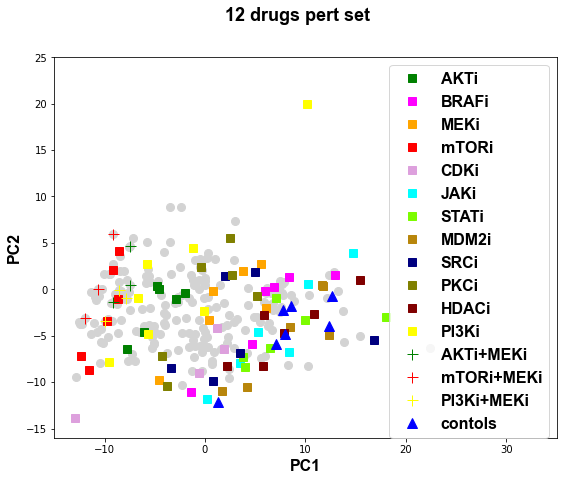

In [10]:
# 2D visualization
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

plt.suptitle('12 drugs pert set',**fontTitle)

#xscale = pca.explained_variance_ratio_[0]
#yscale = pca.explained_variance_ratio_[1]

ax.plot(PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,1],'o',color='lightgrey',ms=8) 

ax.plot(PCA_TPM.loc[drugs12pert_AKTi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_AKTi.index].iloc[:,1],'s',color='green',label='AKTi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_RAFi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_RAFi.index].iloc[:,1],'s',color='magenta',label='BRAFi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_MEKi.index].iloc[:,1],'s',color='orange',label='MEKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_mTORi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_mTORi.index].iloc[:,1],'s',color='red',label='mTORi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_CDKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_CDKi.index].iloc[:,1],'s',color='plum',label='CDKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_JAKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_JAKi.index].iloc[:,1],'s',color='cyan',label='JAKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_STATi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_STATi.index].iloc[:,1],'s',color='lawngreen',label='STATi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_MDM2i.index].iloc[:,0],PCA_TPM.loc[drugs12pert_MDM2i.index].iloc[:,1],'s',color='darkgoldenrod',label='MDM2i',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_SRCi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_SRCi.index].iloc[:,1],'s',color='navy',label='SRCi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_PKCi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PKCi.index].iloc[:,1],'s',color='olive',label='PKCi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_HDACi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_HDACi.index].iloc[:,1],'s',color='maroon',label='HDACi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_PI3Ki.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PI3Ki.index].iloc[:,1],'s',color='yellow',label='PI3Ki',ms=8) 

ax.plot(PCA_TPM.loc[drugs12pert_AKTi_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_AKTi_MEKi.index].iloc[:,1],'+',color='green',label='AKTi+MEKi',ms=11) 
ax.plot(PCA_TPM.loc[drugs12pert_mTORi_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_mTORi_MEKi.index].iloc[:,1],'+',color='red',label='mTORi+MEKi',ms=11) 
ax.plot(PCA_TPM.loc[drugs12pert_PI3Ki_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PI3Ki_MEKi.index].iloc[:,1],'+',color='yellow',label='PI3Ki+MEKi',ms=11) 


ax.plot(PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,1],'^',color='blue',label='contols',ms=10) 


#for smpl in drugs12pert.index:
#    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

ax.set_xlim(-15,35)
ax.set_ylim(-16,25)

ax.legend(numpoints=1,prop=fontLabel,ncol=1)
plt.show()

# we see that the strongest impact is given by PI3K-AKT-mTOR signalling axis
# the negative PC1 direction is roughly the VEM-sensitivity direction
# one of ZS|0.6 is an outlier

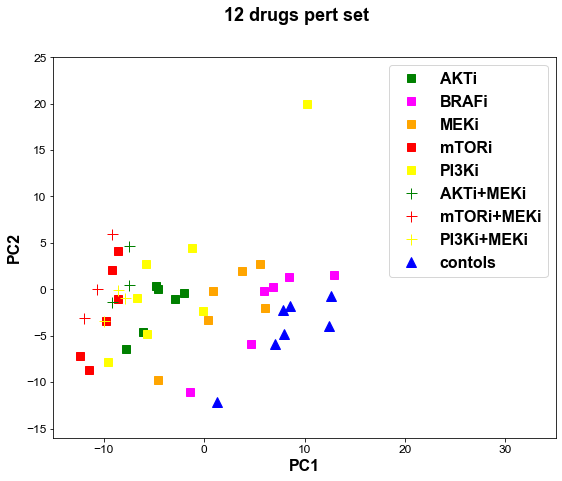

In [11]:
# 2D visualization
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

plt.suptitle('12 drugs pert set',**fontTitle)

#xscale = pca.explained_variance_ratio_[0]
#yscale = pca.explained_variance_ratio_[1]

#ax.plot(PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,1],'o',color='lightgrey',ms=8) 

ax.plot(PCA_TPM.loc[drugs12pert_AKTi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_AKTi.index].iloc[:,1],'s',color='green',label='AKTi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_RAFi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_RAFi.index].iloc[:,1],'s',color='magenta',label='BRAFi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_MEKi.index].iloc[:,1],'s',color='orange',label='MEKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_mTORi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_mTORi.index].iloc[:,1],'s',color='red',label='mTORi',ms=8) 
#ax.plot(PCA_TPM.loc[drugs12pert_CDKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_CDKi.index].iloc[:,1],'s',color='plum',label='CDKi',ms=8) 
#ax.plot(PCA_TPM.loc[drugs12pert_JAKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_JAKi.index].iloc[:,1],'s',color='cyan',label='JAKi',ms=8) 
#ax.plot(PCA_TPM.loc[drugs12pert_STATi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_STATi.index].iloc[:,1],'s',color='lawngreen',label='STATi',ms=8) 
#ax.plot(PCA_TPM.loc[drugs12pert_MDM2i.index].iloc[:,0],PCA_TPM.loc[drugs12pert_MDM2i.index].iloc[:,1],'s',color='darkgoldenrod',label='MDM2i',ms=8) 
#ax.plot(PCA_TPM.loc[drugs12pert_SRCi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_SRCi.index].iloc[:,1],'s',color='navy',label='SRCi',ms=8) 
#ax.plot(PCA_TPM.loc[drugs12pert_PKCi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PKCi.index].iloc[:,1],'s',color='olive',label='PKCi',ms=8) 
#ax.plot(PCA_TPM.loc[drugs12pert_HDACi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_HDACi.index].iloc[:,1],'s',color='maroon',label='HDACi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_PI3Ki.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PI3Ki.index].iloc[:,1],'s',color='yellow',label='PI3Ki',ms=8) 

ax.plot(PCA_TPM.loc[drugs12pert_AKTi_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_AKTi_MEKi.index].iloc[:,1],'+',color='green',label='AKTi+MEKi',ms=11) 
ax.plot(PCA_TPM.loc[drugs12pert_mTORi_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_mTORi_MEKi.index].iloc[:,1],'+',color='red',label='mTORi+MEKi',ms=11) 
ax.plot(PCA_TPM.loc[drugs12pert_PI3Ki_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PI3Ki_MEKi.index].iloc[:,1],'+',color='yellow',label='PI3Ki+MEKi',ms=11) 


ax.plot(PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,1],'^',color='blue',label='contols',ms=10) 


#for smpl in drugs12pert.index:
#    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

ax.set_xlim(-15,35)
ax.set_ylim(-16,25)

ax.legend(numpoints=1,prop=fontLabel,ncol=1)
plt.show()

# we see that the strongest impact is given by PI3K-AKT-mTOR signalling axis
# the negative PC1 direction is roughly the VEM-sensitivity direction
# one of ZS|0.6 is an outlier

In [14]:
drug12_ctrl_PCA       = PCA_TPM.loc[drugs12pert_ctrl.index]
drug12_AKTi_MEKi_PCA  = PCA_TPM.loc[drugs12pert_AKTi_MEKi.index]
drug12_PI3Ki_MEKi_PCA = PCA_TPM.loc[drugs12pert_PI3Ki_MEKi.index]
drug12_mTORi_MEKi_PCA = PCA_TPM.loc[drugs12pert_mTORi_MEKi.index]

drug12_dead_PCA = pd.concat([drug12_AKTi_MEKi_PCA,drug12_PI3Ki_MEKi_PCA,drug12_mTORi_MEKi_PCA],axis=0)
drug12_trainset_PCA = pd.concat([drug12_ctrl_PCA,drug12_AKTi_MEKi_PCA,drug12_PI3Ki_MEKi_PCA,drug12_mTORi_MEKi_PCA],axis=0)
cls_PCA = list(np.full(len(drug12_ctrl_PCA.index),0)) + list(np.full(len(drug12_AKTi_MEKi_PCA.index),1)) + list(np.full(len(drug12_PI3Ki_MEKi_PCA.index),1)) + list(np.full(len(drug12_mTORi_MEKi_PCA.index),1))

svc_PCA = SVC(kernel='linear')
svc_PCA.fit(drug12_trainset_PCA,cls_PCA)

print(svc_PCA.intercept_)


[array([ 0.80931923, -0.54956523,  0.20731726])]
[0.06606098]


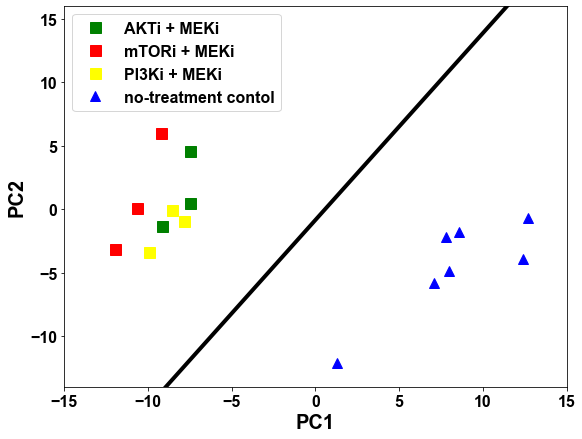

In [15]:
# 2D visualization
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

#plt.suptitle('12 drugs pert set',**fontTitle)

#ax.plot(PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,1],'o',color='lightgrey',ms=8) 

y_ = lambda x: (-svc_PCA.intercept_-svc_PCA.coef_[0][0]*x) / svc_PCA.coef_[0][1]
xs = np.linspace(min(drug12_trainset_PCA.iloc[:,0]),max(drug12_trainset_PCA.iloc[:,0]),10)
ys = y_(xs)
ax.plot(xs,ys,'-',linewidth=4,color='black')

ax.plot(PCA_TPM.loc[drugs12pert_AKTi_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_AKTi_MEKi.index].iloc[:,1],'s',color='green',label='AKTi + MEKi',ms=11) 
ax.plot(PCA_TPM.loc[drugs12pert_mTORi_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_mTORi_MEKi.index].iloc[:,1],'s',color='red',label='mTORi + MEKi',ms=11) 
ax.plot(PCA_TPM.loc[drugs12pert_PI3Ki_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PI3Ki_MEKi.index].iloc[:,1],'s',color='yellow',label='PI3Ki + MEKi',ms=11) 


ax.plot(PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,1],'^',color='blue',label='no-treatment contol',ms=10) 


#for smpl in drugs12pert.index:
#    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

ax.set_xlim(-15,15)
ax.set_ylim(-14,16)

ax.legend(numpoints=1,prop=fontAxes,ncol=1)
plt.show()

# we see that the strongest impact is given by PI3K-AKT-mTOR signalling axis
# the negative PC1 direction is roughly the VEM-sensitivity direction
# one of ZS|0.6 is an outlier

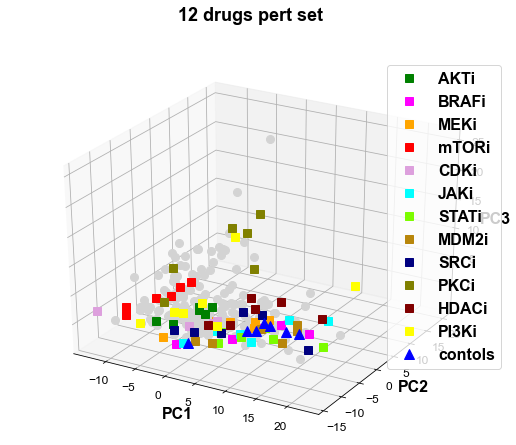

In [12]:
# 3D visualization
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
#ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

plt.suptitle('12 drugs pert set',**fontTitle)

#xscale = pca.explained_variance_ratio_[0]
#yscale = pca.explained_variance_ratio_[1]

ax.plot(PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,1],PCA_TPM.loc[drugs12pert_nonctrl.index].iloc[:,2],'o',color='lightgrey',ms=8) 

ax.plot(PCA_TPM.loc[drugs12pert_AKTi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_AKTi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_AKTi.index].iloc[:,2],'s',color='green',label='AKTi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_RAFi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_RAFi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_RAFi.index].iloc[:,2],'s',color='magenta',label='BRAFi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_MEKi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_MEKi.index].iloc[:,2],'s',color='orange',label='MEKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_mTORi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_mTORi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_mTORi.index].iloc[:,2],'s',color='red',label='mTORi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_CDKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_CDKi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_CDKi.index].iloc[:,2],'s',color='plum',label='CDKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_JAKi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_JAKi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_JAKi.index].iloc[:,2],'s',color='cyan',label='JAKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_STATi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_STATi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_STATi.index].iloc[:,2],'s',color='lawngreen',label='STATi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_MDM2i.index].iloc[:,0],PCA_TPM.loc[drugs12pert_MDM2i.index].iloc[:,1],PCA_TPM.loc[drugs12pert_MDM2i.index].iloc[:,2],'s',color='darkgoldenrod',label='MDM2i',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_SRCi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_SRCi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_SRCi.index].iloc[:,2],'s',color='navy',label='SRCi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_PKCi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PKCi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_PKCi.index].iloc[:,2],'s',color='olive',label='PKCi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_HDACi.index].iloc[:,0],PCA_TPM.loc[drugs12pert_HDACi.index].iloc[:,1],PCA_TPM.loc[drugs12pert_HDACi.index].iloc[:,2],'s',color='maroon',label='HDACi',ms=8) 
ax.plot(PCA_TPM.loc[drugs12pert_PI3Ki.index].iloc[:,0],PCA_TPM.loc[drugs12pert_PI3Ki.index].iloc[:,1],PCA_TPM.loc[drugs12pert_PI3Ki.index].iloc[:,2],'s',color='yellow',label='PI3Ki',ms=8) 

ax.plot(PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,0],PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,1],PCA_TPM.loc[drugs12pert_ctrl.index].iloc[:,2],'^',color='blue',label='contols',ms=10) 


#for smpl in PCA_TPM.index:
#    ax.text(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1],PCA_TPM.loc[smpl][2],smpl)

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
ax.set_zlabel('PC3',**fontLabel)

#ax.set_xlim(-30000,75000)
#ax.set_ylim(-10000,20000)

ax.legend(numpoints=1,prop=fontLabel,ncol=1)
plt.show()


In [13]:
# Visualization of 4 drug pert set

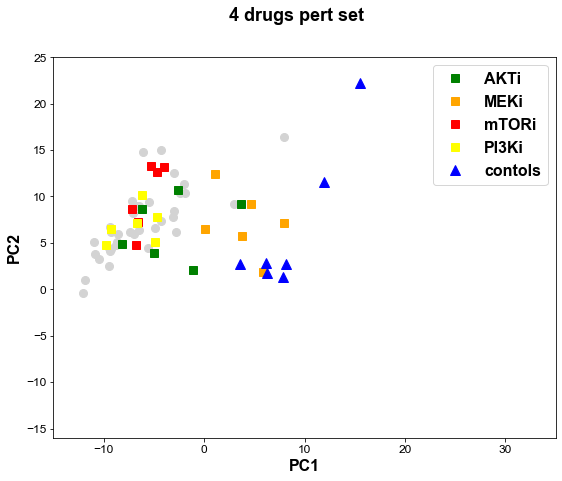

In [14]:
# 2D visualization
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

plt.suptitle('4 drugs pert set',**fontTitle)

#xscale = pca.explained_variance_ratio_[0]
#yscale = pca.explained_variance_ratio_[1]

ax.plot(PCA_TPM.loc[drugs4pert_nonctrl.index].iloc[:,0],PCA_TPM.loc[drugs4pert_nonctrl.index].iloc[:,1],'o',color='lightgrey',ms=8) 

ax.plot(PCA_TPM.loc[drugs4pert_AKTi.index].iloc[:,0],PCA_TPM.loc[drugs4pert_AKTi.index].iloc[:,1],'s',color='green',label='AKTi',ms=8) 
ax.plot(PCA_TPM.loc[drugs4pert_MEKi.index].iloc[:,0],PCA_TPM.loc[drugs4pert_MEKi.index].iloc[:,1],'s',color='orange',label='MEKi',ms=8) 
ax.plot(PCA_TPM.loc[drugs4pert_mTORi.index].iloc[:,0],PCA_TPM.loc[drugs4pert_mTORi.index].iloc[:,1],'s',color='red',label='mTORi',ms=8) 
ax.plot(PCA_TPM.loc[drugs4pert_PI3Ki.index].iloc[:,0],PCA_TPM.loc[drugs4pert_PI3Ki.index].iloc[:,1],'s',color='yellow',label='PI3Ki',ms=8) 

ax.plot(PCA_TPM.loc[drugs4pert_ctrl.index].iloc[:,0],PCA_TPM.loc[drugs4pert_ctrl.index].iloc[:,1],'^',color='blue',label='contols',ms=10) 


#for smpl in drugs4pert.index:
#    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

ax.set_xlim(-15,35)
ax.set_ylim(-16,25)

ax.legend(numpoints=1,prop=fontLabel,ncol=1)
plt.show()


In [15]:
# Visualization of PLX dose response

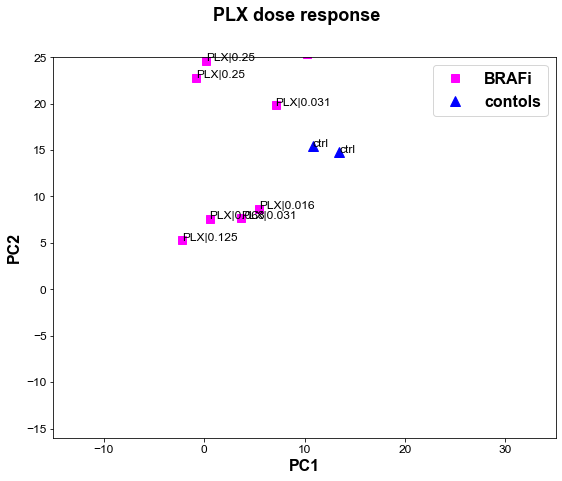

In [16]:
# 2D visualization
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

plt.suptitle('PLX dose response',**fontTitle)

#xscale = pca.explained_variance_ratio_[0]
#yscale = pca.explained_variance_ratio_[1]

ax.plot(PCA_TPM.loc[PLX_DR_RAFi.index].iloc[:,0],PCA_TPM.loc[PLX_DR_RAFi.index].iloc[:,1],'s',color='magenta',label='BRAFi',ms=8) 

ax.plot(PCA_TPM.loc[PLX_DR_ctrl.index].iloc[:,0],PCA_TPM.loc[PLX_DR_ctrl.index].iloc[:,1],'^',color='blue',label='contols',ms=10) 


for smpl in PLX_DR.index:
    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

ax.set_xlim(-15,35)
ax.set_ylim(-16,25)

ax.legend(numpoints=1,prop=fontLabel,ncol=1)
plt.show()


In [17]:
# Visualization of EGF time course

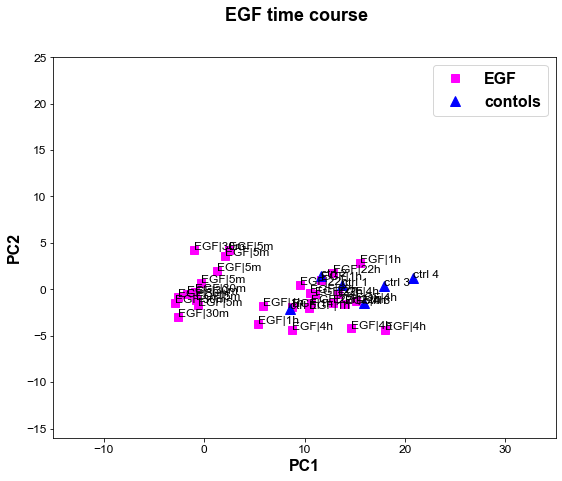

In [18]:
# 2D visualization
fig = plt.figure(figsize=(9,7))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 18} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
fontAxes =  {'family' : 'Arial', 'weight' : 'normal', 'size' : 12} 
plt.rc('font', **fontAxes)

plt.suptitle('EGF time course',**fontTitle)

#xscale = pca.explained_variance_ratio_[0]
#yscale = pca.explained_variance_ratio_[1]

ax.plot(PCA_TPM.loc[EGF_TC_LG.index].iloc[:,0],PCA_TPM.loc[EGF_TC_LG.index].iloc[:,1],'s',color='magenta',label='EGF',ms=8) 

ax.plot(PCA_TPM.loc[EGF_TC_ctrl.index].iloc[:,0],PCA_TPM.loc[EGF_TC_ctrl.index].iloc[:,1],'^',color='blue',label='contols',ms=10) 


for smpl in EGF_TC.index:
    ax.annotate(RPPA_legend.loc[smpl]['Sample Description (drug abbre. | dose or time-point)'],(PCA_TPM.loc[smpl][0],PCA_TPM.loc[smpl][1]))

ax.set_xlabel('PC1',**fontLabel)
ax.set_ylabel('PC2',**fontLabel)
#ax.set_zlabel('PC3',**fontLabel)

ax.set_xlim(-15,35)
ax.set_ylim(-16,25)

ax.legend(numpoints=1,prop=fontLabel,ncol=1)
plt.show()


In [19]:
# OK, so, the signalling pattern seems to be comprehensively explained by 12 drgus pert set

In [20]:
# picking doses for STV
ptb_1 = "AK"
ptb_2 = "ZS"
ptb_3 = 'Tm'

drugs12pert_pert_1  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_1 + '\|\d+\.*\d*$',regex=True)]
dose_list_1 = list(set(drugs12pert_pert_1['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_1)
drugs12pert_pert_2  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_2 + '\|\d+\.*\d*$',regex=True)]
dose_list_2 = list(set(drugs12pert_pert_2['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_2)
drugs12pert_pert_3  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_3 + '\|\d+\.*\d*$',regex=True)]
dose_list_3 = list(set(drugs12pert_pert_3['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_3)

# preparing training dataset
#perts_STV = ['AK|10','ZS|1.2','Tm|0.6']
drugs12pert_pert_1high = drugs12pert_pert_1[drugs12pert_pert_1['Sample Description (drug abbre. | dose or time-point)'] == 'AK|10'].index
drugs12pert_pert_2high = drugs12pert_pert_2[drugs12pert_pert_2['Sample Description (drug abbre. | dose or time-point)'] == 'ZS|1.2'].index
drugs12pert_pert_3high = drugs12pert_pert_3[drugs12pert_pert_3['Sample Description (drug abbre. | dose or time-point)'] == 'Tm|0.6'].index
drugs12_pert_index = list(drugs12pert_pert_1high) + list(drugs12pert_pert_2high) + list(drugs12pert_pert_3high)
drugs12_pert_index

['AK|10', 'AK|5']
['ZS|0.6', 'ZS|1.2']
['Tm|0.3', 'Tm|0.6']


['wq|36',
 'wq|172',
 'wq|225',
 'wq|37',
 'wq|176',
 'wq|226',
 'wq|54',
 'wq|184',
 'wq|264']

In [21]:
# building STV

drug12_ctrl = RPPA_total.loc[drugs12pert_ctrl.index]

drug12_AKTi_MEKi = RPPA_total.loc[drugs12pert_AKTi_MEKi.index]
drug12_PI3Ki_MEKi = RPPA_total.loc[drugs12pert_PI3Ki_MEKi.index]
drug12_mTORi_MEKi = RPPA_total.loc[drugs12pert_mTORi_MEKi.index]

drug12_dead = pd.concat([drug12_AKTi_MEKi,drug12_PI3Ki_MEKi,drug12_mTORi_MEKi],axis=0)
ctrl_cnt = drug12_ctrl.mean(axis=0)
dead_cnt = drug12_dead.mean(axis=0)

drug12_trainset = pd.concat([drug12_ctrl,drug12_AKTi_MEKi,drug12_PI3Ki_MEKi,drug12_mTORi_MEKi],axis=0)
cls = list(np.full(len(drug12_ctrl.index),0)) + list(np.full(len(drug12_AKTi_MEKi.index),1)) + list(np.full(len(drug12_PI3Ki_MEKi.index),1)) + list(np.full(len(drug12_mTORi_MEKi.index),1))

#drug12_train = RPPA_total.loc[drugs12_pert_index]

#drug12_trainset = pd.concat([drug12_ctrl,drug12_train],axis=0)
#cls = list(np.full(len(drug12_ctrl.index),0)) + list(np.full(len(drug12_train.index),1))

svc = SVC(kernel='linear')
svc.fit(drug12_trainset,cls)
b_coeff = svc.intercept_[0]/linalg.norm(svc.coef_[0])
norm_vec = - svc.coef_[0]/linalg.norm(svc.coef_[0])
s_vec = (ctrl_cnt - dead_cnt)/linalg.norm(ctrl_cnt - dead_cnt)

norm_vec_df = pd.DataFrame(s_vec,index=RPPA_total.columns,columns=['s_vec'])
norm_vec_df.insert(0,'norm_vec',norm_vec)
# plot STV ranking
norm_vec_df.to_csv('Sander_STV.csv')
norm_vec_df.sort_values(by='s_vec')

# minus is higher in VEM-sensitive state
# plus is higher in VEM-resistant state

,norm_vec,s_vec
SRC_GBL9007059.txt,-0.140135,-0.157848
SRC_GBL9007055.txt,-0.159722,-0.129159
Caveolin_V_GBL9007006.txt,-0.119310,-0.109400
Calveolin.V._GBL9007280.txt,-0.110349,-0.099560
b.Catenin_V_GBL9007000.txt,-0.155847,-0.098230
...,...,...
S6_pS240.V._GBL9007070.txt,0.182366,0.164854
S6_pS235_V_GBL9007270.txt,0.288817,0.258976
CyclinB1.V._GBL9007281.txt,0.229616,0.279245
CyclinB1_V_GBL9007008.txt,0.225351,0.309660


In [22]:
norm_vec_df.filter(regex="Myc",axis=0)
# Myc has positive contribution to STV, OK

,norm_vec,s_vec
c.Myc_GBL9006959.txt,0.002595,0.002581
c.Myc_pT58_GBL9007257.txt,-0.001495,-0.000713
c.Myc_pT58_GBL9007121.txt,-0.000662,-0.000923
c.Myc_pT58_GBL9007179.txt,-0.000862,-0.000717


['AK|10', 'AK|5']
['ZS|0.6', 'ZS|1.2']
['Tm|0.3', 'Tm|0.6']


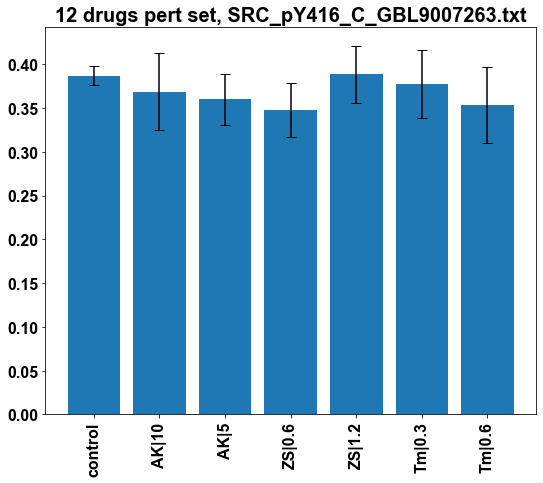

In [23]:
# making bar plot for specific protein for 12 drug pert set
# a handy (IMHO) tool to quickly look for some specific data
gene_name = "SRC_pY416_C_GBL9007263.txt"
ptb_1 = "AK"
ptb_2 = "ZS"
ptb_3 = 'Tm'

drugs12pert_pert_1  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_1 + '\|\d+\.*\d*$',regex=True)]
dose_list_1 = list(set(drugs12pert_pert_1['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_1)
drugs12pert_pert_2  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_2 + '\|\d+\.*\d*$',regex=True)]
dose_list_2 = list(set(drugs12pert_pert_2['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_2)
drugs12pert_pert_3  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_3 + '\|\d+\.*\d*$',regex=True)]
dose_list_3 = list(set(drugs12pert_pert_3['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_3)

ctrl_gene = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.index][gene_name])
ctrl_gene_err = stats.sem(RPPA_total.loc[drugs12pert_ctrl.index][gene_name])

pert_genes_1 = []
pert_genes_err_1 = []
for dose in dose_list_1:
    pert_samples_names=drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == dose].index
    pert_genes_1.append(statistics.mean(RPPA_total.loc[pert_samples_names][gene_name]))
    pert_genes_err_1.append(stats.sem(RPPA_total.loc[pert_samples_names][gene_name]))

pert_genes_2 = []
pert_genes_err_2 = []
for dose in dose_list_2:
    pert_samples_names=drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == dose].index
    pert_genes_2.append(statistics.mean(RPPA_total.loc[pert_samples_names][gene_name]))
    pert_genes_err_2.append(stats.sem(RPPA_total.loc[pert_samples_names][gene_name]))

pert_genes_3 = []
pert_genes_err_3 = []
for dose in dose_list_3:
    pert_samples_names=drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == dose].index
    pert_genes_3.append(statistics.mean(RPPA_total.loc[pert_samples_names][gene_name]))
    pert_genes_err_3.append(stats.sem(RPPA_total.loc[pert_samples_names][gene_name]))


names = ['control'] + dose_list_1 + dose_list_2 + dose_list_3
values = [ctrl_gene] + pert_genes_1 + pert_genes_2 + pert_genes_3
errs = [ctrl_gene_err] + pert_genes_err_1 + pert_genes_err_2 + pert_genes_err_3

fig = plt.figure(figsize=(8,7))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

plt.title('12 drugs pert set, ' + gene_name,**fontTitle)
plt.bar(names,values,yerr=errs,capsize=5)
plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()

['SR|4.8', 'SR|2.4']
['901|1.5', '901|3']
['RO|3.5', 'RO|7']


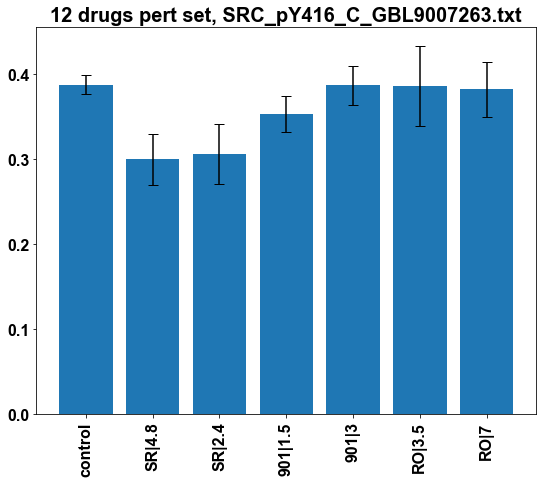

In [24]:
# making bar plot for specific protein for 12 drug pert set
# a handy (IMHO) tool to quickly look for some specific data
gene_name = "SRC_pY416_C_GBL9007263.txt"
ptb_1 = "SR"
ptb_2 = "901"
ptb_3 = "RO"

drugs12pert_pert_1  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_1 + '\|\d+\.*\d*$',regex=True)]
dose_list_1 = list(set(drugs12pert_pert_1['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_1)
drugs12pert_pert_2  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_2 + '\|\d+\.*\d*$',regex=True)]
dose_list_2 = list(set(drugs12pert_pert_2['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_2)
drugs12pert_pert_3  = drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'].str.contains(pat='^' + ptb_3 + '\|\d+\.*\d*$',regex=True)]
dose_list_3 = list(set(drugs12pert_pert_3['Sample Description (drug abbre. | dose or time-point)']))
print(dose_list_3)

ctrl_gene = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.index][gene_name])
ctrl_gene_err = stats.sem(RPPA_total.loc[drugs12pert_ctrl.index][gene_name])

pert_genes_1 = []
pert_genes_err_1 = []
for dose in dose_list_1:
    pert_samples_names=drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == dose].index
    pert_genes_1.append(statistics.mean(RPPA_total.loc[pert_samples_names][gene_name]))
    pert_genes_err_1.append(stats.sem(RPPA_total.loc[pert_samples_names][gene_name]))

pert_genes_2 = []
pert_genes_err_2 = []
for dose in dose_list_2:
    pert_samples_names=drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == dose].index
    pert_genes_2.append(statistics.mean(RPPA_total.loc[pert_samples_names][gene_name]))
    pert_genes_err_2.append(stats.sem(RPPA_total.loc[pert_samples_names][gene_name]))

pert_genes_3 = []
pert_genes_err_3 = []
for dose in dose_list_3:
    pert_samples_names=drugs12pert.loc[drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == dose].index
    pert_genes_3.append(statistics.mean(RPPA_total.loc[pert_samples_names][gene_name]))
    pert_genes_err_3.append(stats.sem(RPPA_total.loc[pert_samples_names][gene_name]))


names = ['control'] + dose_list_1 + dose_list_2 + dose_list_3
values = [ctrl_gene] + pert_genes_1 + pert_genes_2 + pert_genes_3
errs = [ctrl_gene_err] + pert_genes_err_1 + pert_genes_err_2 + pert_genes_err_3

fig = plt.figure(figsize=(8,7))
fontTitle = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontLabel = {'family' : 'Arial', 'weight' : 'bold', 'size' : 20} 
fontAxes =  {'family' : 'Arial', 'weight' : 'bold', 'size' : 16} 
plt.rc('font', **fontAxes)

plt.title('12 drugs pert set, ' + gene_name,**fontTitle)
plt.bar(names,values,yerr=errs,capsize=5)
plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()

# point RY|4 must be excluded

In [25]:
# core network: MEK/ERK (ERK), PI3K/AKT (AKT), mTOR/S6K (TOR), SRC, CDK, PKC, IRS
# 6 perturbed, 2 unperturbed, 8 in total
# assigining outputs to different modules

ERK_module_names = ['EGFR_pY1173_C_GBL9007098.txt','EGFR_pY992_V_GBL9007099.txt','EGFR_V_GBL9007097.txt','EGFR_pY1173_C_GBL9007284.txt','EGFR_pY992_V_GBL9007285.txt','EGFR.V._GBL9006975.txt','cRAF_V_GBL9007004.txt','b.RAF_mouse_GBL9007358.txt','b.RAF_pS445_GBL9007254.txt','b.RAF_pS445_GBL9007069.txt','MEK1-2-pS217-221_GBL9006861.txt (correct)','MEK1_V_GBL9007480.txt','MEK1.V._GBL9006980.txt','MAPK_pT202_GBL9007479.txt','MAPK_pT202_GBL9007114.txt','MAPK_pT202_GBL9007178.txt']
ERK_module_output = ['MAPK_pT202_GBL9007178.txt']
ERK_module_output_diag = ['MAPK_pT202_GBL9007178.txt']

AKT_module_names = ['p85PI3K_GBL9006917.txt','PI3K_p110a.C._GBL9006918.txt','AKT_pS473_V_GBL9006995.txt','AKT_pT308_V_GBL9006996.txt','AKT_V_GBL9006994.txt','AKT_pS473_V_GBL9006969.txt','PDK1_pS241_V_GBL9007265.txt','PDK1_V_GBL9006961.txt','PDK1_pS241_V_GBL9007273.txt','PDK1.V._GBL9006984.txt']
AKT_module_output = ['AKT_pS473_V_GBL9006995.txt']
AKT_module_output_diag = ['AKT_pS473_V_GBL9006995.txt']

TOR_module_names = ['mTOR_V_GBL9007482.txt','mTOR_pS2448_GBL9007262.txt','mTOR_pS2448_GBL9007124.txt','p70S6K_V_GBL9007296.txt','p70S6K_pT389_V_GBL9007115.txt','p70S6K_pT389.V._GBL9007103.txt']
TOR_module_output = ['p70S6K_pT389_V_GBL9007115.txt'] # pS6K
TOR_module_output_diag = ['p70S6K_pT389_V_GBL9007115.txt'] # same

# maybe for SRC we should pick other diagnal element
SRC_module_names = ['SRC_V_mouse_GBL9007307.txt','SRC_pY416_C_GBL9007263.txt','SRC_pY527_V_GBL9007268.txt','SRC_GBL9007055.txt','SRC_pY416_C_GBL9007276.txt','SRC_pY527_V_GBL9007272.txt','SRC_GBL9007059.txt','SRC_pY317_GBL9007060.txt']
SRC_module_output = ['SRC_pY416_C_GBL9007263.txt']
SRC_module_output_diag = ['SRC_pY416_C_GBL9007263.txt']

CDK_module_names = ['CyclinD1_V_GBL9007009.txt','Cyclin.D1_V_GBL9007283.txt','Rb_V_mouse_GBL9007306.txt','Rb_pS807_V_GBL9007269.txt','Rb_pS807_V_GBL9007274.txt','Rb_pS807_V_GBL9007274.txt'] #
CDK_module_output = ['Rb_pS807_V_GBL9007274.txt']
CDK_module_output_diag = ['Rb_pS807_V_GBL9007274.txt']

PKC_module_names = ['PKCa_V_mouse_GBL9007305.txt','PKCa_pS657_V_GBL9007267.txt','PKCdelta_pS664_GBL9007266.txt','PKCa_pS657_V_GBL9007127.txt','PKCdelta_pS664_GBL9007126.txt','PKCdelta_pS664_GBL9006912.txt']
PKC_module_output = ['PKCa_pS657_V_GBL9007267.txt'] # phospho-PKCa
PKC_module_output_diag = ['p70S6K_pT389_V_GBL9007115.txt'] # phospho-pS6K

IRS_module_names = ['IGFBP2_V_GBL9006949.txt','IGFRb_C_GBL9006950.txt','IRS1_V_GBL9006951.txt','IRS1_pS307_GBL9007260.txt','IRS1_pS307_GBL9007275.txt','IRS1_pS307_GBL9007066.txt'] #
IRS_module_output = ['IRS1_V_GBL9006951.txt','IRS1_pS307_GBL9007066.txt'] # total IRS - phospho-IRS
IRS_module_output_diag = ['IRS1_V_GBL9006951.txt','IRS1_pS307_GBL9007066.txt'] # none actually


total_proteins = []

#treatments_output = ["JNKinh","MEKinh","AKTinh","JNK8inh","S6Kinh","RSKinh"]
modules_output = [ERK_module_output,AKT_module_output,TOR_module_output,SRC_module_output,CDK_module_output,PKC_module_output,IRS_module_output]
modules_output_diag = [ERK_module_output_diag,AKT_module_output_diag,TOR_module_output_diag,SRC_module_output_diag,CDK_module_output_diag,PKC_module_output_diag,IRS_module_output_diag]

total_names = ERK_module_names + AKT_module_names + TOR_module_names + SRC_module_names + CDK_module_names + PKC_module_names + IRS_module_names + total_proteins
print(modules_output[6])

['IRS1_V_GBL9006951.txt', 'IRS1_pS307_GBL9007066.txt']


In [26]:
RPPA_total_red = RPPA_total.drop(columns=total_names)

drug12_ctrl_red = RPPA_total_red.loc[drugs12pert_ctrl.index]

drug12_AKTi_MEKi_red = RPPA_total_red.loc[drugs12pert_AKTi_MEKi.index]
drug12_PI3Ki_MEKi_red = RPPA_total_red.loc[drugs12pert_PI3Ki_MEKi.index]
drug12_mTORi_MEKi_red = RPPA_total_red.loc[drugs12pert_mTORi_MEKi.index]

drug12_dead_red = pd.concat([drug12_AKTi_MEKi_red,drug12_PI3Ki_MEKi_red,drug12_mTORi_MEKi_red],axis=0)
ctrl_cnt_red = drug12_ctrl_red.mean(axis=0)
dead_cnt_red = drug12_dead_red.mean(axis=0)

In [27]:
#building new STV

drug12_trainset_red = pd.concat([drug12_ctrl_red,drug12_AKTi_MEKi_red,drug12_PI3Ki_MEKi_red,drug12_mTORi_MEKi_red],axis=0)

svc_red = SVC(kernel='linear')
svc_red.fit(drug12_trainset_red,cls)
b_red = svc_red.intercept_[0]/linalg.norm(svc_red.coef_[0])
n_vec_red = - svc_red.coef_[0]/linalg.norm(svc_red.coef_[0])
s_vec_red = (ctrl_cnt_red - dead_cnt_red)/linalg.norm(ctrl_cnt_red - dead_cnt_red)

norm_vec_df_red = pd.DataFrame(s_vec_red,index=RPPA_total_red.columns,columns=['s_vec_red'])
norm_vec_df_red.insert(0,'norm_vec_red',n_vec_red)
# plot STV ranking
norm_vec_df_red.to_csv('Sander_reduced_STV.csv')
norm_vec_df_red.sort_values(by='s_vec_red')

# minus is higher in VEM-sensitive state
# plus is higher in VEM-resistant state

,norm_vec_red,s_vec_red
Caveolin_V_GBL9007006.txt,-0.154731,-0.114581
Calveolin.V._GBL9007280.txt,-0.131328,-0.104275
b.Catenin_V_GBL9007000.txt,-0.231173,-0.102881
b.Catenin.V._GBL9007278.txt,-0.153899,-0.053474
YAP_V_GBL9006957.txt,-0.031596,-0.041715
...,...,...
S6_pS240.V._GBL9007070.txt,0.210056,0.172661
S6_pS235_V_GBL9007270.txt,0.319261,0.271241
CyclinB1.V._GBL9007281.txt,0.169088,0.292470
CyclinB1_V_GBL9007008.txt,0.218753,0.324324


In [28]:
norm_vec_df_red.filter(regex="Myc",axis=0)
# Myc has positive contribution to STV, OK

,norm_vec_red,s_vec_red
c.Myc_GBL9006959.txt,0.005071,0.002703
c.Myc_pT58_GBL9007257.txt,-0.003729,-0.000747
c.Myc_pT58_GBL9007121.txt,0.000904,-0.000966
c.Myc_pT58_GBL9007179.txt,-0.000745,-0.000751


In [29]:
# calculate DPDs

DPDs = pd.DataFrame(columns=['DPD_value'],index=drugs12pert.index)

for smpl in DPDs.index:
    DPD_val = -(b_red - np.dot(RPPA_total_red.loc[smpl],norm_vec_df_red['norm_vec_red']))/np.dot(norm_vec_df_red['s_vec_red'],norm_vec_df_red['norm_vec_red'])
    DPDs.at[smpl,'DPD_value'] = DPD_val
DPDs.insert(1,'Sample Description (drug abbre. | dose or time-point)',drugs12pert['Sample Description (drug abbre. | dose or time-point)'])
DPDs.insert(2,'series / replications  on one slide',drugs12pert['series / replications  on one slide'])

DPDs.loc[drugs12pert_ctrl.index].sort_values(by='Sample Description (drug abbre. | dose or time-point)')

,DPD_value,Sample Description (drug abbre. | dose or time-point),series / replications on one slide
Sample Name (in RPPA data from Yiling),,,
wq|38,7.10693,ctrl 1,r1
wq|1,9.62971,ctrl 2,r1
wq|82,9.94127,ctrl 3,r1
wq|149,13.0078,ctrl 4,r2
wq|218,12.213,ctrl 5,r3
wq|265,9.28036,ctrl 6,r3
wq|171,8.65455,ctrl 7,r2


In [30]:
DPDs.loc[drugs12pert_mTORi.index].sort_values(by='Sample Description (drug abbre. | dose or time-point)')

,DPD_value,Sample Description (drug abbre. | dose or time-point),series / replications on one slide
Sample Name (in RPPA data from Yiling),,,
wq|108,-6.97053,Tm|0.3,r2
wq|209,-6.85901,Tm|0.3,r3
wq|21,-6.26865,Tm|0.3,r1
wq|54,-7.94683,Tm|0.6,r1
wq|184,-8.63383,Tm|0.6,r2
wq|264,-9.08986,Tm|0.6,r3


In [31]:
# stage 1 - small doses

In [32]:
# we have 3 replicates and we will collate everything replicate-by-replicate
# for IRS the output is (total - phospho)

module_names = ['ERK','AKT','mTOR','SRC','CDK','PKC','IRS','DPD']
#pert_doses = pd.DataFrame(['901|3','AK|10','Tm|0.6','SR|4.8','RY|2','RO|7'],index=['ERKi','AKTi','mTORi','SRCi','CDKi','PKCi'],columns=['Drug_dose'])
pert_doses = pd.DataFrame(['901|1.5','AK|5','Tm|0.3','SR|2.4','RY|2','RO|3.5'],index=['ERKi','AKTi','mTORi','SRCi','CDKi','PKCi'],columns=['Drug_dose'])
replicates = 3
perturbations = []
for inh in pert_doses.index:
    #if inh == 'CDKi':
    #    perturbations.append('CDKi_1')
    #else:
    for repl in range(replicates):
        perturbations.append(inh + '_' + str(repl+1))

R_global = pd.DataFrame(np.zeros((len(module_names),len(perturbations))),columns=perturbations,index=module_names)
#R_global

In [33]:
# calculate global response matrix elements

# filling signalling part
for mod_idx in range(len(module_names)-1):
    for pert_idx in range(len(pert_doses.index)):
        if (module_names[mod_idx] == pert_doses.index[pert_idx][:-1]):
            #print(module_names[mod_idx] + ', ' + modules_output_diag[mod_idx][0] + ', ' + pert_doses.index[pert_idx])
            # diagonal part
            #if (pert_doses.index[pert_idx] == 'CDKi'):
            #    # we have only one replicate here at the moment
            #    rpl = 'r1'
            #    if (module_names[mod_idx] == 'IRS'):
            #        x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
            #        x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
            #        x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][1]])
            #        x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][1]])
            #        R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
            #        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
            #    else:
            #        x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
            #        x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
            #        R_g = 2*(x_1-x_0)/(x_1+x_0)
            #        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
            #else:
            # 3 replicates
            for repl in range(replicates):
                rpl = 'r' + str(repl+1)
                if (module_names[mod_idx] == 'IRS'):
                    x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
                    x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
                    x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][1]])
                    x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][1]])
                    R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g
                else:
                    x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
                    x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
                    R_g = 2*(x_1-x_0)/(x_1+x_0)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g
        else:
            #print(module_names[mod_idx] + ', ' + modules_output[mod_idx][0] + ', ' + pert_doses.index[pert_idx])
            # non-diagonal part
            #if (pert_doses.index[pert_idx] == 'CDKi'):
            #    # we have only one replicate here at the moment
            #    rpl = 'r1'
            #    if (module_names[mod_idx] == 'IRS'):
            #        x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
            #        x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
            #        x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][1]])
            #        x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][1]])
            #        R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
            #        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
            #    else:
            #        x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
            #        x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
            #        R_g = 2*(x_1-x_0)/(x_1+x_0)
            #        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
            #else:
            # 3 replicates
            for repl in range(replicates):
                rpl = 'r' + str(repl+1)
                if (module_names[mod_idx] == 'IRS'):
                    x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
                    x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
                    x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][1]])
                    x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][1]])
                    R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g
                else:
                    x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
                    x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
                    R_g = 2*(x_1-x_0)/(x_1+x_0)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g

# phenotpyic part
for pert_idx in range(len(pert_doses.index)):
    #if (pert_doses.index[pert_idx] == 'CDKi'):
    #    rpl = 'r1'
    #    x_0 = statistics.mean(DPDs.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index]['DPD_value'])
    #    x_1 = statistics.mean(DPDs.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index]['DPD_value'])
    #    R_g = 2*(x_1-x_0)/(x_1+x_0)
    #    R_global.at['DPD',pert_doses.index[pert_idx] + '_1'] = R_g
    #else:
    for repl in range(replicates):
        rpl = 'r' + str(repl+1)
        x_0 = statistics.mean(DPDs.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index]['DPD_value'])
        x_1 = statistics.mean(DPDs.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index]['DPD_value'])
        #R_g = 2*(x_1-x_0)/(x_1+x_0)
        R_g = (x_1-x_0)/(x_0)
        R_global.at['DPD',pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g

R_global


,ERKi_1,ERKi_2,ERKi_3,AKTi_1,AKTi_2,AKTi_3,mTORi_1,mTORi_2,mTORi_3,SRCi_1,SRCi_2,SRCi_3,CDKi_1,CDKi_2,CDKi_3,PKCi_1,PKCi_2,PKCi_3
ERK,-0.484303,-0.728999,-0.461505,-0.223290,-0.429742,-0.121698,-0.184207,-0.253717,-0.253816,-0.218100,-0.269375,-0.068151,0.045473,0.018849,-0.051003,0.208895,0.260168,0.217650
AKT,0.025549,0.142960,-0.057656,-1.327541,-1.499342,-1.493715,0.806128,0.932736,0.832573,-0.053795,-0.129379,-0.115530,0.223897,0.011928,0.141809,-0.254601,-0.024568,-0.146631
mTOR,-0.513350,-0.441493,-0.519917,-0.676237,-0.738430,-0.663269,-1.028061,-0.909580,-1.051271,-0.377724,-0.417535,-0.320572,-0.560435,-0.268969,-0.441284,-0.455072,-0.536987,-0.434589
SRC,-0.058830,-0.040773,-0.141044,0.002478,-0.065767,-0.127845,0.084054,-0.005207,-0.135457,-0.109172,-0.223142,-0.366899,0.001615,-0.083208,-0.117100,0.092376,-0.187703,0.083682
CDK,-0.364819,-0.396311,-0.488584,-0.326701,-0.292955,-0.362509,-0.127495,-0.080629,-0.279677,-0.070636,-0.058370,-0.288033,-0.349244,-0.437437,-0.440929,-0.284733,-0.180942,-0.302951
PKC,0.075593,0.117812,0.215724,-0.146279,-0.014175,0.097331,0.008978,-0.109970,0.168702,0.029482,-0.077461,0.277942,-0.183891,-0.099599,-0.081055,-0.455072,-0.536987,-0.434589
IRS,-0.014783,-0.015294,-0.145785,0.267036,0.460155,0.265428,0.525517,0.469920,0.619148,-0.010899,-0.051354,0.155864,0.292289,0.000195,0.333012,0.602344,0.552012,0.667158
DPD,-0.793751,-0.417021,-0.637406,-1.341979,-1.179915,-1.147736,-1.704925,-1.643563,-1.638243,-0.341980,-0.399559,0.571630,-0.617570,-0.713735,-0.576453,-0.843148,-0.947012,-0.603169


In [34]:
R_global.to_csv('SKMEL_133_R_global_noMyc_smallDoses.csv')

In [35]:
# stage 2 - high doses

In [36]:
# we have 3 replicates and we will collate everything replicate-by-replicate
# for IRS the output is (total - phospho)

module_names = ['ERK','AKT','mTOR','SRC','CDK','PKC','IRS','DPD']
pert_doses = pd.DataFrame(['901|3','AK|10','Tm|0.6','SR|4.8','RY|4','RO|7'],index=['ERKi','AKTi','mTORi','SRCi','CDKi','PKCi'],columns=['Drug_dose'])
#pert_doses = pd.DataFrame(['901|1.5','AK|5','Tm|0.3','SR|2.4','RY|2','RO|3.5'],index=['ERKi','AKTi','mTORi','SRCi','CDKi','PKCi'],columns=['Drug_dose'])
replicates = 3
perturbations = []
for inh in pert_doses.index:
    if inh == 'CDKi':
        perturbations.append('CDKi_1')
    else:
        for repl in range(replicates):
            perturbations.append(inh + '_' + str(repl+1))

R_global = pd.DataFrame(np.zeros((len(module_names),len(perturbations))),columns=perturbations,index=module_names)
#R_global

In [37]:
# calculate global response matrix elements

# filling signalling part
for mod_idx in range(len(module_names)-1):
    for pert_idx in range(len(pert_doses.index)):
        if (module_names[mod_idx] == pert_doses.index[pert_idx][:-1]):
            #print(module_names[mod_idx] + ', ' + modules_output_diag[mod_idx][0] + ', ' + pert_doses.index[pert_idx])
            # diagonal part
            if (pert_doses.index[pert_idx] == 'CDKi'):
                # we have only one replicate here at the moment
                rpl = 'r1'
                if (module_names[mod_idx] == 'IRS'):
                    x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
                    x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
                    x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][1]])
                    x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][1]])
                    R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
                else:
                    x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
                    x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
                    R_g = 2*(x_1-x_0)/(x_1+x_0)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
            else:
                # 3 replicates
                for repl in range(replicates):
                    rpl = 'r' + str(repl+1)
                    if (module_names[mod_idx] == 'IRS'):
                        x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
                        x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
                        x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][1]])
                        x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][1]])
                        R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
                        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g
                    else:
                        x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output_diag[mod_idx][0]])
                        x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output_diag[mod_idx][0]])
                        R_g = 2*(x_1-x_0)/(x_1+x_0)
                        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g
        else:
            #print(module_names[mod_idx] + ', ' + modules_output[mod_idx][0] + ', ' + pert_doses.index[pert_idx])
            # non-diagonal part
            if (pert_doses.index[pert_idx] == 'CDKi'):
                # we have only one replicate here at the moment
                rpl = 'r1'
                if (module_names[mod_idx] == 'IRS'):
                    x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
                    x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
                    x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][1]])
                    x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][1]])
                    R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
                else:
                    x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
                    x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
                    R_g = 2*(x_1-x_0)/(x_1+x_0)
                    R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_1'] = R_g
            else:
            # 3 replicates
                for repl in range(replicates):
                    rpl = 'r' + str(repl+1)
                    if (module_names[mod_idx] == 'IRS'):
                        x_0_p = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
                        x_1_p = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
                        x_0_n = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][1]])
                        x_1_n = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][1]])
                        R_g = 2*(x_1_p-x_0_p)/(x_1_p+x_0_p) - 2*(x_1_n-x_0_n)/(x_1_n+x_0_n)
                        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g
                    else:
                        x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][modules_output[mod_idx][0]])
                        x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][modules_output[mod_idx][0]])
                        R_g = 2*(x_1-x_0)/(x_1+x_0)
                        R_global.at[module_names[mod_idx],pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g

# phenotpyic part
for pert_idx in range(len(pert_doses.index)):
    if (pert_doses.index[pert_idx] == 'CDKi'):
        rpl = 'r1'
        x_0 = statistics.mean(DPDs.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index]['DPD_value'])
        x_1 = statistics.mean(DPDs.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index]['DPD_value'])
        #R_g = 2*(x_1-x_0)/(x_1+x_0)
        R_g = (x_1-x_0)/(x_0)
        R_global.at['DPD',pert_doses.index[pert_idx] + '_1'] = R_g
    else:
        for repl in range(replicates):
            rpl = 'r' + str(repl+1)
            x_0 = statistics.mean(DPDs.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index]['DPD_value'])
            x_1 = statistics.mean(DPDs.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses.iloc[pert_idx]['Drug_dose']) & (drugs12pert['series / replications  on one slide'] == rpl)].index]['DPD_value'])
            #R_g = 2*(x_1-x_0)/(x_1+x_0)
            R_g = (x_1-x_0)/(x_0)
            R_global.at['DPD',pert_doses.index[pert_idx] + '_' + str(repl+1)] = R_g

R_global


,ERKi_1,ERKi_2,ERKi_3,AKTi_1,AKTi_2,AKTi_3,mTORi_1,mTORi_2,mTORi_3,SRCi_1,SRCi_2,SRCi_3,CDKi_1,PKCi_1,PKCi_2,PKCi_3
ERK,-0.671602,-0.864483,-0.701034,-0.136632,-0.196497,-0.262983,0.010714,-0.176546,-0.008662,-0.212593,-0.170520,-0.145405,0.895773,0.368159,0.350745,0.403153
AKT,0.099713,0.301769,0.215884,-1.522385,-1.567746,-1.556270,1.029363,1.065123,1.183420,-0.122542,-0.234448,-0.120268,-0.181013,0.029694,0.137908,0.208120
mTOR,-0.496762,-0.428450,-0.548146,-0.751716,-0.698416,-0.781754,-1.081337,-1.091631,-1.169045,-0.400929,-0.542299,-0.385511,-0.900532,-0.306616,-0.409370,-0.221730
SRC,0.034951,0.031329,-0.037364,0.083392,-0.163298,-0.061855,0.054917,-0.154018,-0.166953,-0.154425,-0.222519,-0.368428,1.148746,0.067418,-0.026943,-0.058784
CDK,-0.611152,-0.680323,-0.614613,-0.101750,-0.182602,-0.192526,-0.102436,-0.229988,-0.184915,-0.286535,-0.321259,-0.291741,-1.088847,-0.133552,-0.253778,-0.222098
PKC,0.104709,0.119375,0.207398,0.102128,0.108381,0.055293,0.014283,-0.026761,0.075426,-0.045208,0.028714,0.116034,0.122776,-0.306616,-0.409370,-0.221730
IRS,-0.054768,-0.008871,-0.308578,0.471411,0.410105,0.468404,0.519498,0.380043,0.390885,0.053575,-0.219374,-0.087310,0.964668,0.745535,0.746991,0.687398
DPD,-0.946272,-0.918129,-0.719760,-1.448043,-1.363983,-1.376696,-1.893642,-1.797130,-1.845828,-0.887521,-0.743718,-0.628031,-1.690325,-1.114632,-1.193411,-1.182699


In [38]:
R_global.to_csv('SKMEL_133_R_global_noMyc_highDoses.csv')

In [39]:
# next we must prepare files for fitting

In [40]:
#out_names = ['FC_tIRS','FC_IRSI','FC_pERK','FC_pAKT','FC_pSRC','FC_pPKC','FC_pS6K','FC_pRB']
output_ABs = pd.DataFrame(['IRS1_V_GBL9006951.txt','IRS1_pS307_GBL9007066.txt','MAPK_pT202_GBL9007178.txt','AKT_pS473_V_GBL9006995.txt','SRC_pY416_C_GBL9007263.txt','PKCa_pS657_V_GBL9007267.txt','p70S6K_pT389_V_GBL9007115.txt','Rb_pS807_V_GBL9007274.txt'],index=['FC_tIRS','FC_IRSI','FC_pERK','FC_pAKT','FC_pSRC','FC_pPKC','FC_pS6K','FC_pRB'],columns=['AB_names'])
output_errs = pd.DataFrame(['FC_tIRS_SD','FC_IRSI_SD','FC_pERK_SD','FC_pAKT_SD','FC_pSRC_SD','FC_pPKC_SD','FC_pS6K_SD','FC_pRB_SD'],index=['FC_tIRS','FC_IRSI','FC_pERK','FC_pAKT','FC_pSRC','FC_pPKC','FC_pS6K','FC_pRB'],columns=['err_names'])
outputs_total = pd.concat([output_ABs,output_errs],axis=1)

pert_doses_h = pd.DataFrame(['901|3','AK|10','Tm|0.6','SR|4.8','RY|4','RO|7'],index=['ERKinh','AKTinh','mTORinh','SRCinh','CDKinh','PKCinh'],columns=['Drug_dose_high'])
pert_doses_l = pd.DataFrame(['901|1.5','AK|5','Tm|0.3','SR|2.4','RY|2','RO|3.5'],index=['ERKinh','AKTinh','mTORinh','SRCinh','CDKinh','PKCinh'],columns=['Drug_dose_low'])
pert_doses_total = pd.concat([pert_doses_l,pert_doses_h],axis=1)
replicates=3

#outputs_total

In [44]:
# filling signalling exp-files
for pert_name in pert_doses_total.index:
    # filling low doses
    exp_file_vals = pd.DataFrame(np.ones((2,len(outputs_total.index))),index=[0,86400],columns=outputs_total.index)
    exp_file_errs = pd.DataFrame(np.zeros((2,len(outputs_total.index))),index=[0,86400],columns=outputs_total['err_names'])
    exp_file=pd.concat([exp_file_vals,exp_file_errs],axis=1)
    exp_file.index.name='# time'
    for out_name in outputs_total.index:
        vals=[]
        for rpl_i in range(replicates):
            rpl = 'r' + str(rpl_i+1)
            x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][outputs_total.loc[out_name,'AB_names']])
            x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses_total.loc[pert_name]['Drug_dose_low']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][outputs_total.loc[out_name,'AB_names']])
            vals.append(x_1/x_0)
        exp_file.at[86400,out_name]=statistics.mean(vals)
        exp_file.at[86400,outputs_total.loc[out_name,'err_names']]=stats.sem(vals)
    exp_file.to_csv('dose1_' + pert_name + '.exp',sep='\t')

    # filling high doses
    if (pert_name == 'CDKinh'):
        # only 1 replicate
        exp_file = pd.DataFrame(np.ones((2,len(outputs_total.index))),index=[0,86400],columns=outputs_total.index)
        exp_file.index.name='# time'
        for out_name in outputs_total.index:
            vals=[]
            rpl = 'r1'
            x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][outputs_total.loc[out_name,'AB_names']])
            x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses_total.loc[pert_name]['Drug_dose_high']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][outputs_total.loc[out_name,'AB_names']])
            vals.append(x_1/x_0)
            exp_file.at[86400,out_name]=statistics.mean(vals)
    else:
        # 3 replicates
        exp_file_vals = pd.DataFrame(np.ones((2,len(outputs_total.index))),index=[0,86400],columns=outputs_total.index)
        exp_file_errs = pd.DataFrame(np.zeros((2,len(outputs_total.index))),index=[0,86400],columns=outputs_total['err_names'])
        exp_file=pd.concat([exp_file_vals,exp_file_errs],axis=1)
        exp_file.index.name='# time'
        for out_name in outputs_total.index:
            vals=[]
            for rpl_i in range(replicates):
                rpl = 'r' + str(rpl_i+1)
                x_0 = statistics.mean(RPPA_total.loc[drugs12pert_ctrl.loc[drugs12pert_ctrl['series / replications  on one slide'] == rpl].index][outputs_total.loc[out_name,'AB_names']])
                x_1 = statistics.mean(RPPA_total.loc[drugs12pert.loc[(drugs12pert['Sample Description (drug abbre. | dose or time-point)'] == pert_doses_total.loc[pert_name]['Drug_dose_high']) & (drugs12pert['series / replications  on one slide'] == rpl)].index][outputs_total.loc[out_name,'AB_names']])
                vals.append(x_1/x_0)
            exp_file.at[86400,out_name]=statistics.mean(vals)
            exp_file.at[86400,outputs_total.loc[out_name,'err_names']]=stats.sem(vals)
    exp_file.to_csv('dose2_' + pert_name + '.exp',sep='\t')



In [35]:
# now we have to fill STV module points - DMSO
time_points = [0,10,45]
Smodule_names = ['Sval','Sval_SD']
timecourse_A_S = pd.DataFrame(np.zeros((len(time_points),len(Smodule_names))),columns=Smodule_names,index=time_points)
timecourse_A_S.index.name='time'
timecourse_B_S = pd.DataFrame(np.zeros((len(time_points),len(Smodule_names))),columns=Smodule_names,index=time_points)
timecourse_B_S.index.name='time'

for tpnt in time_points:
    S_A = []
    S_B = []
    for replicate_ in range(replicates_DMSO):
        replicate = replicate_ + 1
        #if tpnt == 0:
        #    S_A_val = -(b_red - np.dot(np.ones(len(n_vec_red)),n_vec_red))/np.dot(norm_vec_red,n_vec_red)
        #    S_B_val = -(b_red - np.dot(np.ones(len(n_vec_red)),n_vec_red))/np.dot(norm_vec_red,n_vec_red)
        #    S_A.append(S_A_val)
        #    S_B.append(S_B_val)
        #else:
        S_A_val = -(b_red - np.dot(RPPA_total_norm_red['TrkA_DMSO_'+ str(tpnt) +'_r'+str(replicate)],n_vec_red))/np.dot(norm_vec_red,n_vec_red)
        S_B_val = -(b_red - np.dot(RPPA_total_norm_red['TrkB_DMSO_'+ str(tpnt) +'_r'+str(replicate)],n_vec_red))/np.dot(norm_vec_red,n_vec_red)
        S_A.append(S_A_val)
        S_B.append(S_B_val)
    timecourse_A_S['Sval'][tpnt] = statistics.mean(S_A)
    timecourse_B_S['Sval'][tpnt] = statistics.mean(S_B)
    if tpnt != 0:
        timecourse_A_S['Sval_SD'][tpnt] = stats.sem(S_A)
        timecourse_B_S['Sval_SD'][tpnt] = stats.sem(S_B)

#timecourse_A['Sval_SD'][0] = statistics.mean([timecourse_A['Sval_SD'][10],timecourse_A['Sval_SD'][45]])
#timecourse_B['Sval_SD'][0] = statistics.mean([timecourse_B['Sval_SD'][10],timecourse_B['Sval_SD'][45]])


In [36]:
timecourse_A_S.to_csv('timecourse_A_S.exp',sep='\t')
timecourse_A_S

,Sval,Sval_SD
time,,
0,-3.794948,0.000000
10,-3.322345,0.243939
45,-2.312873,0.308081


In [37]:
timecourse_B_S.to_csv('timecourse_B_S.exp',sep='\t')
timecourse_B_S

,Sval,Sval_SD
time,,
0,-3.794948,0.000000
10,-2.125368,0.168909
45,5.722422,0.599511


In [38]:
# now we have to fill STV module points - perturbations
time_points = [10,45]
Smodule_names = ['Sval','Sval_SD']

for treatment in treatments_output:
    timecourse_A_S_pert = pd.DataFrame(np.zeros((len(time_points),len(Smodule_names))),columns=Smodule_names,index=time_points)
    timecourse_A_S_pert.index.name='time'
    timecourse_B_S_pert = pd.DataFrame(np.zeros((len(time_points),len(Smodule_names))),columns=Smodule_names,index=time_points)
    timecourse_B_S_pert.index.name='time'
    for tpnt in time_points:
        S_A = []
        S_B = []
        for replicate_ in range(replicates_rest):
            if treatment in treatments_1:
                replicate = replicate_ + 1
            elif treatment in treatments_2:
                replicate = replicate_ + 4
            else:
                replicate = replicate_ + 1
            if treatment == 'JNKinh':
                pert_name = 'TRKinh'
            elif treatment == 'JNK8inh':
                pert_name = 'JNKinh'
            elif treatment == 'MEKinh':
                pert_name = 'ERKinh'
            else:
                pert_name = treatment
            #if tpnt == 0:
            #    S_A_val = -(b_red - np.dot(np.ones(len(n_vec_red)),n_vec_red))/np.dot(norm_vec_red,n_vec_red)
            #    S_B_val = -(b_red - np.dot(np.ones(len(n_vec_red)),n_vec_red))/np.dot(norm_vec_red,n_vec_red)
            #    S_A.append(S_A_val)
            #    S_B.append(S_B_val)
            #else:
            S_A_val = -(b_red - np.dot(RPPA_total_norm_red['TrkA_'+treatment+'_'+ str(tpnt) +'_r'+str(replicate)],n_vec_red))/np.dot(norm_vec_red,n_vec_red)
            S_B_val = -(b_red - np.dot(RPPA_total_norm_red['TrkB_'+treatment+'_'+ str(tpnt) +'_r'+str(replicate)],n_vec_red))/np.dot(norm_vec_red,n_vec_red)
            S_A.append(S_A_val)
            S_B.append(S_B_val)
        timecourse_A_S_pert['Sval'][tpnt] = statistics.mean(S_A)
        timecourse_B_S_pert['Sval'][tpnt] = statistics.mean(S_B)
        timecourse_A_S_pert['Sval_SD'][tpnt] = stats.sem(S_A)
        timecourse_B_S_pert['Sval_SD'][tpnt] = stats.sem(S_B)
    #print(timecourse_A_S_pert)
    #print(timecourse_B_S_pert)
    timecourse_A_S_pert.to_csv('timecourse2_A_S_' + pert_name + '.exp',sep='\t')
    timecourse_B_S_pert.to_csv('timecourse2_B_S_' + pert_name + '.exp',sep='\t')

